In [2]:
import pandas as pd 
import numpy as np 
import os 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import lightgbm as lgbm
import catboost
from sklearn.metrics import mean_squared_error

## Reading data. No missing data and no categorical data. All good it seems.

In [3]:
train = pd.read_csv('train.csv')
train.drop('id',axis=1,inplace=True)

In [4]:
train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,...,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,-0.109948,...,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,...,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,...,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,0.692665,...,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0


## Also getting original dataset

In [5]:
og_dataset = pd.read_csv('creditcard.csv')

In [6]:
# let's try to just add the examples in og_dataset that have Class==1 ==> terrible idea
#og_dataset_class_is_1 = og_dataset[og_dataset.Class==1].copy()
#train = pd.concat([train,og_dataset_class_is_1])

In [7]:
train = pd.concat([train,og_dataset])

## 0.2% (469) of the labels are 1s... extremely unbalanced dataset

In [8]:
train.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

## Quick check of features to see if there is any of them that looks particularly weird

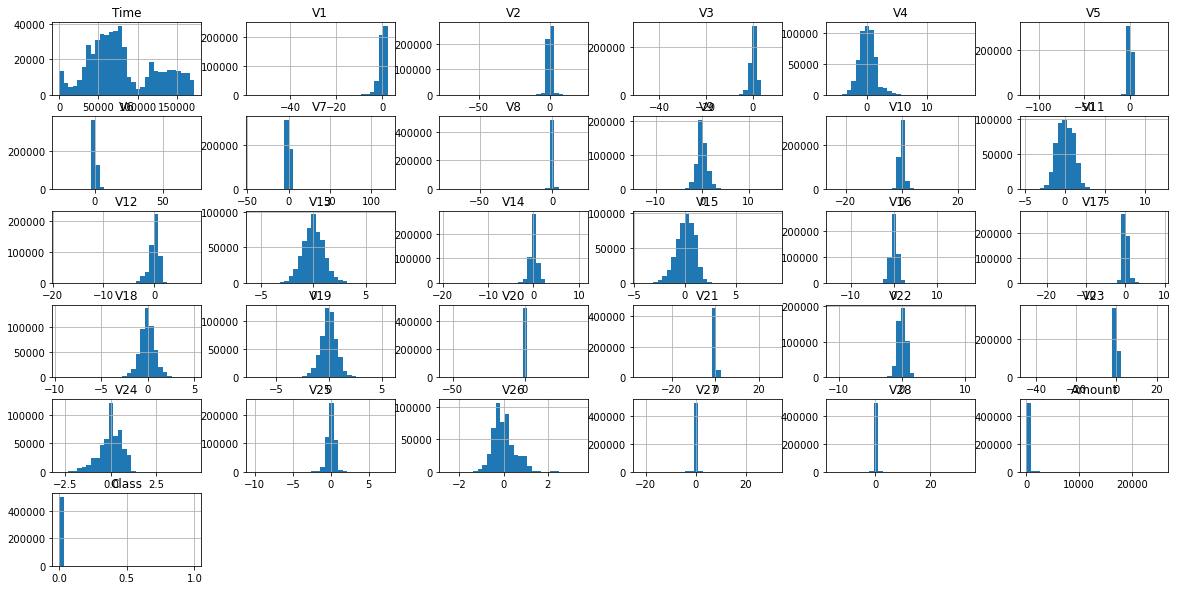

In [9]:
train.hist(bins=30, figsize=(20, 10))
plt.show()

In [10]:
# defining features and target 
features = [c for c in train if c not in ['Class']]
target = 'Class'

In [11]:
len(train)

503936

In [12]:
# Getting rid of outliers
from scipy import stats
#train = train[(np.abs(stats.zscore(train[features])) < 5).all(axis=1)].copy()

In [13]:
len(train)

503936

In [14]:
# splitting train and validation 
# Splitting training set - startified to get a good repartition of Attrition everywhere 
x = train[features]
y = train[target]
x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=0.05, stratify = y)

## Training a simple XGBoost

In [214]:
# defining an xgboost regressor
# regularisation parameters were found through trial and error. can probably be improved
xg_reg = xgb.XGBRegressor(
            objective='reg:pseudohubererror',
            tree_method="hist",
            n_estimators=1000,
            learning_rate=0.0075,
            reg_lambda = 0.3,
            reg_alpha = 0.2,
            max_leaves = 17,
            subsample=0.50,
            colsample_bytree=0.50,
            max_bin=4096,
            n_jobs=2,
            eval_metric='auc',
            early_stopping_rounds=70,
        )
xg_reg.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_validation,y_validation)],verbose=200)

[0]	validation_0-auc:0.73827	validation_1-auc:0.74517
[200]	validation_0-auc:0.85107	validation_1-auc:0.82708
[269]	validation_0-auc:0.85124	validation_1-auc:0.82251


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=70, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.0075, max_bin=4096, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=17, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=2, num_parallel_tree=1, objective='reg:pseudohubererror',
              predictor='auto', random_state=0, reg_alpha=0.2, ...)

## Grid search on XGBoost parameters to try and find better


In [15]:
cv_params = {'alpha':[0.5,1,1.5]}    # parameters to be tried in the grid search
fix_params = {'learning_rate':0.05,'max_depth':6,'max_leaves':20,'tree_method':'hist','n_estimators': 4999,'early_stopping_rounds':70 ,'objective': 'reg:logistic',
              'subsample':0.3,'colsample_bytree':0.3,'max_bin':4096,'n_jobs':2,"eval_metric":'auc','lambda':0.5}   #other parameters, fixed for the moment 
csv = GridSearchCV(xgb.XGBRegressor(**fix_params), cv_params, scoring = 'roc_auc', cv = 2)

In [ ]:
csv.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_validation,y_validation)],verbose=1000)

In [216]:
csv.best_score_

0.8931604813272565

In [217]:
csv.best_params_

{'alpha': 1.5}

## Get the best params found by the grid search in the fix_params

In [16]:
fix_params['alpha'] = 1.5
#fix_params['objective'] = 'reg:logistic'

In [22]:
params_final = fix_params

xg_reg = xgb.XGBRegressor(**params_final)
xg_reg.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_validation,y_validation)],verbose=200)

[0]	validation_0-auc:0.69069	validation_1-auc:0.72863
[200]	validation_0-auc:0.95392	validation_1-auc:0.90705
[217]	validation_0-auc:0.95964	validation_1-auc:0.89506


XGBRegressor(alpha=1.5, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=70, enable_categorical=False,
             eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='', lambda=0.5,
             learning_rate=0.05, max_bin=4096, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=20, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=4999,
             n_jobs=2, num_parallel_tree=1, objective='reg:logistic',
             predictor='auto', ...)

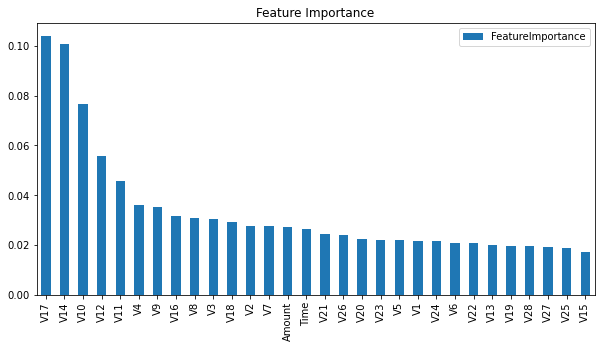

In [18]:
fi =pd.DataFrame(data=xg_reg.feature_importances_,index=xg_reg.feature_names_in_,columns=['FeatureImportance']).sort_values(by='FeatureImportance',ascending=False)
fi.plot.bar(title='Feature Importance',figsize=(10,5))
plt.show()

## LGBM model

In [31]:
# random params but feel free to tune
lgbm_params = {'n_estimators': 500,
                 'num_rounds': 274,
                 'learning_rate': 0.05,
                 'num_leaves': 195,
                 'max_depth': 9,
                 'min_data_in_leaf': 46,
                 'lambda_l2': 0.6,
                 'bagging_fraction': 0.45,
                 'feature_fraction': 0.3,
                 'eval_metric':'auc'}

In [38]:
lgbm_reg = lgbm.LGBMRegressor(**lgbm_params)

# cross_validate(X_train, y, lgbm_clf)

lgbm_reg.fit(x_train, y_train, verbose=100,eval_set=[(x_train,y_train),(x_validation,y_validation)])

/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	training's l2: 0.00105435	valid_1's l2: 0.00113892
[200]	training's l2: 0.000964885	valid_1's l2: 0.00111592


LGBMRegressor(bagging_fraction=0.45, eval_metric='auc', feature_fraction=0.3,
              lambda_l2=0.6, learning_rate=0.05, max_depth=9,
              min_data_in_leaf=46, n_estimators=500, num_leaves=195,
              num_rounds=274)

## CatBoost

In [52]:
catboost_params = {'loss_function': 'Poisson',
                     'learning_rate': 0.05,
                     'colsample_bylevel': 0.06,
                     'depth': 1,
                     'boosting_type': 'Plain',
                     'bootstrap_type': 'Bernoulli',
                     'min_data_in_leaf': 18,
                     'one_hot_max_size': 14,
                     'subsample': 0.8,
                    'eval_metric':'AUC'}

catboost_reg = catboost.CatBoostRegressor(**catboost_params)

# cross_validate(X_train, y, catboost_clf)

catboost_reg.fit(x_train, y_train,eval_set=[(x_train,y_train),(x_validation,y_validation)], verbose=200)

0:	test: 0.5024455	test1: 0.5190688	best: 0.5190688 (0)	total: 31.1ms	remaining: 31s
200:	test: 0.8711296	test1: 0.8764149	best: 0.8769906 (193)	total: 3.76s	remaining: 14.9s
400:	test: 0.8827910	test1: 0.8829344	best: 0.8831663 (322)	total: 7.06s	remaining: 10.5s
600:	test: 0.8894172	test1: 0.8840966	best: 0.8862927 (495)	total: 10.3s	remaining: 6.87s
800:	test: 0.8950311	test1: 0.8945829	best: 0.8947046 (794)	total: 13.6s	remaining: 3.38s
999:	test: 0.8986025	test1: 0.8975759	best: 0.8985103 (928)	total: 16.9s	remaining: 0us

bestTest = 0.8985102953
bestIteration = 928

Shrink model to first 929 iterations.


## Get a prediction

In [229]:
sample_submission = pd.read_csv('sample_submission.csv')

In [53]:
test = pd.read_csv('test.csv')

In [231]:
predictions = xg_reg.predict(test[features])

In [54]:
# Prediction ensembling the 3 models
xgb_preds = xg_reg.predict(test[features])
#lgbm_preds = lgbm_reg.predict(test[features])
cat_preds = catboost_reg.predict(test[features])
predictions = np.column_stack([cat_preds]).mean(axis=1)

In [55]:
submission = test[['id']].copy()
submission['Class'] = predictions

In [56]:
submission.to_csv('MySubmission_W_OG_Data_CatBoost.csv',index=None)

In [234]:
#Logisitic is better
#Classifier is terrible